# Linear Regression

[Book](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple

$$y = ax + b$$

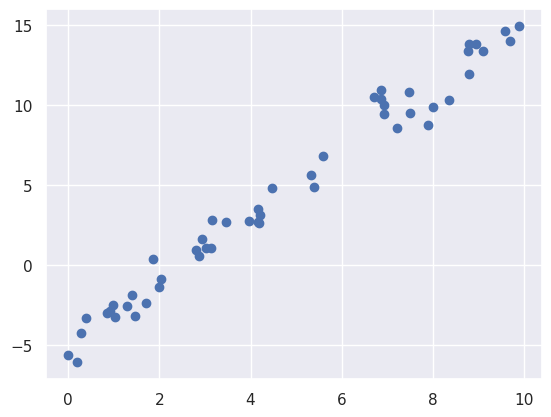

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

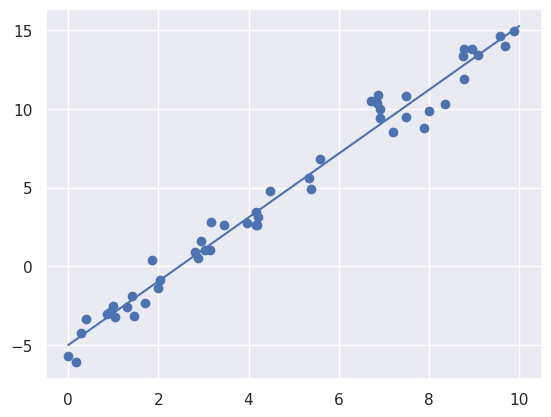

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [4]:
print(f'Slope: {model.coef_.astype(float).round(3)}\nIntercept: {model.intercept_}')

Slope: [2.027]
Intercept: -4.998577085553202


In [5]:
model.coef_.astype(float)

array([2.02720881])

## Basis Function Regression

### Polynomical basis functions

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(
    PolynomialFeatures(7),
    LinearRegression()
)

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

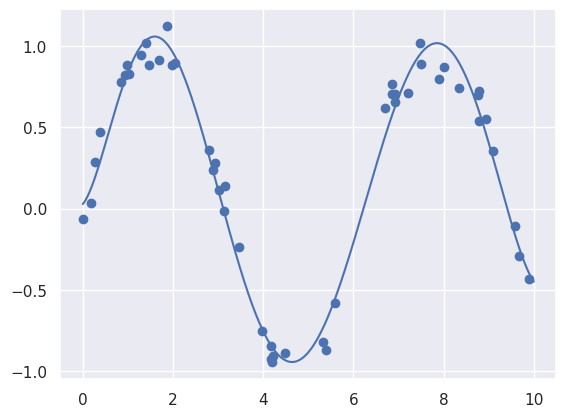

In [9]:
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gausian basis functions

<img src="data/05.06-gaussian-basis.png" />

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    def __init__(self, N, width_factor=2.0) -> None:
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:,:,np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [11]:
gauss_model = make_pipeline(
    GaussianFeatures(20),
    LinearRegression()
)

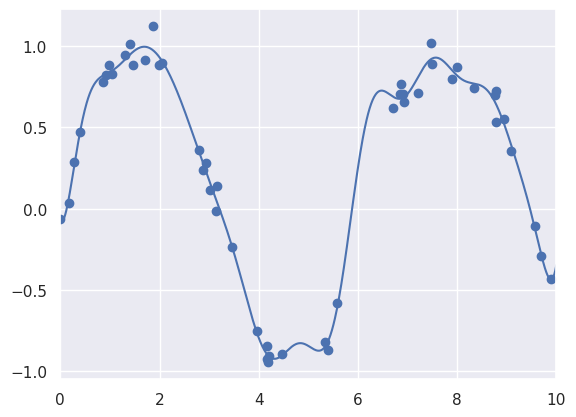

In [12]:
gauss_model.fit(x[:,np.newaxis], y)
yfit = gauss_model.predict(xfit[:,np.newaxis])
plt.scatter(x,y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# Regularization

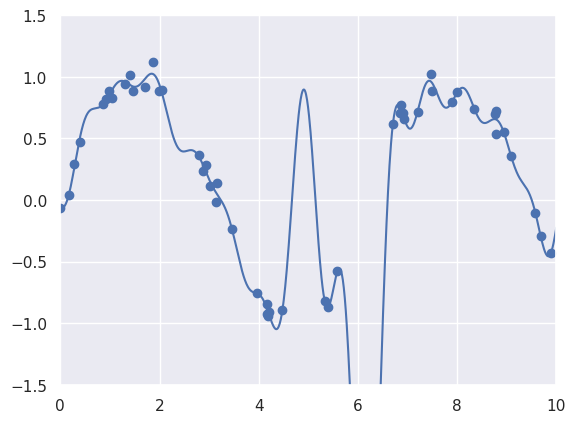

In [13]:
# Overfitting, too many basis functions
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

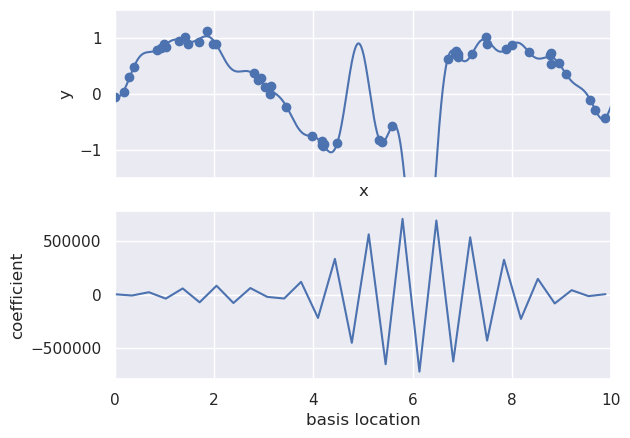

In [14]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model);

## Ridge regression ($L_2$)

Penalty based on sum of squares of the coefficients.

$$P = \alpha\sum_{n=1}^N \theta_n^2$$

with $\alpha$ as a free parameter which increases the penalty as it increases from 0.

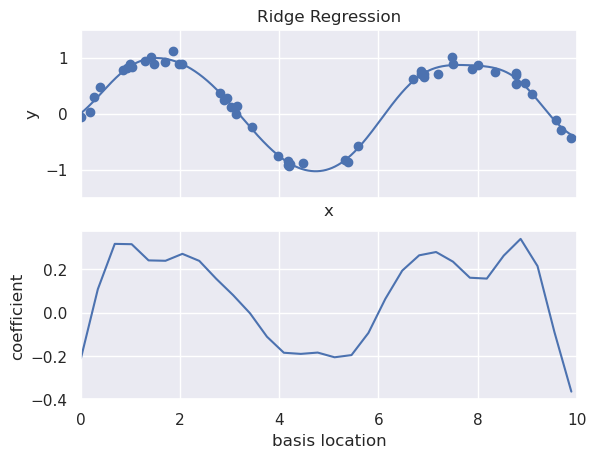

In [15]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

## Lasso regression ($L_1$ regularization)

Good for sparse models, preferentially sets coefficients to 0.

$$P = \alpha\sum_{n=1}^N |\theta_n|$$

/home/biscotty/.config/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


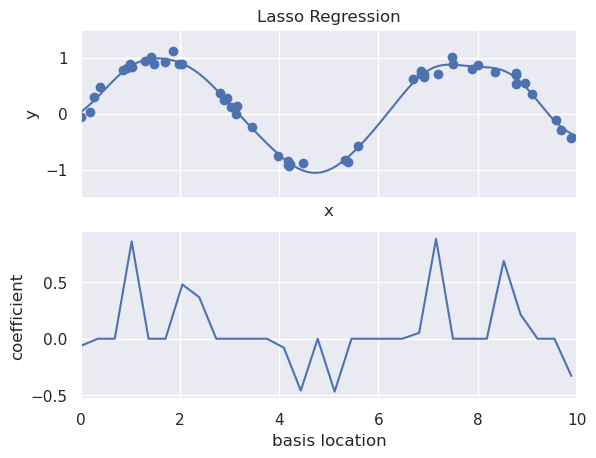

In [16]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

# Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors. We have seen this data already in Working With Time Series.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily weather station data (I used station ID USW00024233) and we can easily use Pandas to join the two data sources. We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

`# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD`

In [17]:
import pandas as pd
data = pd.read_pickle('data/counts.pkl')

In [18]:
data.head()

,Total,West,East
Date,,,
2012-10-03 00:00:00,13.0,9.0,4.0
2012-10-03 01:00:00,10.0,6.0,4.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,3.0,2.0
2012-10-03 04:00:00,7.0,1.0,6.0


In [19]:
counts = data.copy()
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [21]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [22]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2016-10-27,5634.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-10-28,6404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-10-29,1576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [24]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2016-10-27,5634.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-10-28,6404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-10-29,1576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(8.0, 17.0)

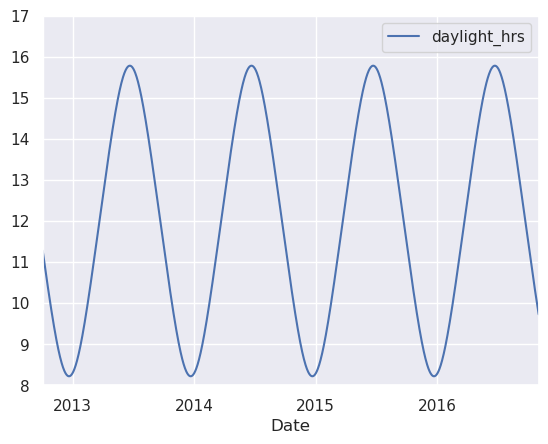

In [35]:
from datetime import datetime
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.to_datetime(datetime(2000, 12, 21))).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.


daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [36]:
seattle_weather = pd.read_csv('data/seattle_weather.csv')
seattle_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          1462 non-null   object 
 1   NAME             1462 non-null   object 
 2   LATITUDE         1462 non-null   float64
 3   LONGITUDE        1462 non-null   float64
 4   ELEVATION        1462 non-null   float64
 5   DATE             1462 non-null   object 
 6   AWND             1462 non-null   float64
 7   AWND_ATTRIBUTES  1462 non-null   object 
 8   PGTM             0 non-null      float64
 9   PGTM_ATTRIBUTES  0 non-null      float64
 10  PRCP             1462 non-null   float64
 11  PRCP_ATTRIBUTES  1462 non-null   object 
 12  SNOW             1462 non-null   float64
 13  SNOW_ATTRIBUTES  1462 non-null   object 
 14  SNWD             1462 non-null   float64
 15  SNWD_ATTRIBUTES  1462 non-null   object 
 16  TAVG             1299 non-null   float64
 17  TAVG_ATTRIBUTE

In [37]:
seattle_weather = seattle_weather.set_index(pd.to_datetime(seattle_weather.DATE))

In [38]:
seattle_weather.index.value_counts()

DATE
2012-10-20    1
2015-06-29    1
2015-06-27    1
2015-06-26    1
2015-06-25    1
             ..
2014-02-17    1
2014-02-16    1
2014-02-15    1
2014-02-14    1
2016-10-20    1
Name: count, Length: 1462, dtype: int64

In [47]:
weather = seattle_weather.copy()

In [49]:
weather['TMIN'] /= 10

In [50]:
weather['TMIN']

DATE
2012-10-20    4.3
2012-10-21    4.0
2012-10-22    3.8
2012-10-23    4.2
2012-10-24    4.3
             ... 
2016-10-16    5.0
2016-10-17    5.0
2016-10-18    4.9
2016-10-19    4.5
2016-10-20    5.0
Name: TMIN, Length: 1462, dtype: float64

In [51]:
weather['TMAX'] /= 10

In [52]:
weather.TMAX

DATE
2012-10-20    5.2
2012-10-21    5.3
2012-10-22    4.6
2012-10-23    5.2
2012-10-24    5.3
             ... 
2016-10-16    6.0
2016-10-17    5.9
2016-10-18    5.8
2016-10-19    5.8
2016-10-20    6.0
Name: TMAX, Length: 1462, dtype: float64

In [53]:
0.5 * (weather.TMIN + weather.TMAX)

DATE
2012-10-20    4.75
2012-10-21    4.65
2012-10-22    4.20
2012-10-23    4.70
2012-10-24    4.80
              ... 
2016-10-16    5.50
2016-10-17    5.45
2016-10-18    5.35
2016-10-19    5.15
2016-10-20    5.50
Length: 1462, dtype: float64

In [54]:
weather['Temp (C)'] = 0.5 * (weather.TMIN + weather.TMAX)

In [55]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,...,WT13_ATTRIBUTES,WT14,WT14_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT22,WT22_ATTRIBUTES,Temp (C)
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-20,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2012-10-20,12.75,",,X",NaN,NaN,...,NaN,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,4.75
2012-10-21,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2012-10-21,6.04,",,X",NaN,NaN,...,",,X",NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,4.65
2012-10-22,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2012-10-22,5.82,",,X",NaN,NaN,...,",,X",NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,4.20
2012-10-23,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2012-10-23,6.71,",,X",NaN,NaN,...,NaN,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,4.70
2012-10-24,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2012-10-24,4.70,",,X",NaN,NaN,...,",,X",NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,4.80


In [56]:
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [59]:
weather.shape

(1462, 58)

In [60]:
daily.shape

(1490, 14)

In [62]:
daily.index.min()

Timestamp('2012-10-03 00:00:00')

In [63]:
daily.index.max()

Timestamp('2016-10-31 00:00:00')

In [64]:
weather.index.min()

Timestamp('2012-10-20 00:00:00')

In [65]:
weather.index.max()

Timestamp('2016-10-20 00:00:00')

In [66]:
daily = daily.loc['2012-10-20':'2016-10-20']
daily.shape

(1462, 14)

In [71]:
local_weather = weather.loc[:,['PRCP', 'Temp (C)', 'dry day']]
local_weather

,PRCP,Temp (C),dry day
DATE,,,
2012-10-20,0.000079,4.75,0
2012-10-21,0.000984,4.65,0
2012-10-22,0.001378,4.20,0
2012-10-23,0.000000,4.70,1
2012-10-24,0.001102,4.80,0
...,...,...,...
2016-10-16,0.002205,5.50,0
2016-10-17,0.000669,5.45,0
2016-10-18,0.000315,5.35,0


In [73]:
daily = daily.join(local_weather, lsuffix='_caller', rsuffix='_other')

In [74]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP_caller,Temp (C)_caller,dry day_caller,annual,PRCP_other,Temp (C)_other,dry day_other
Date,,,,,,,,,,,,,,,,,
2012-10-20,2136.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.310130,0.000079,4.75,0.0,0.046575,0.000079,4.75,0
2012-10-21,1978.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.255305,0.000984,4.65,0.0,0.049315,0.000984,4.65,0
2012-10-22,4258.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.200791,0.001378,4.20,0.0,0.052055,0.001378,4.20,0
2012-10-23,5000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.146603,0.000000,4.70,1.0,0.054795,0.000000,4.70,1
2012-10-24,4858.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.092757,0.001102,4.80,0.0,0.057534,0.001102,4.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-16,978.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.532267,0.002205,5.50,0.0,4.038356,0.002205,5.50,0
2016-10-17,5596.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.476334,0.000669,5.45,0.0,4.041096,0.000669,5.45,0
2016-10-18,5978.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.420659,0.000315,5.35,0.0,4.043836,0.000315,5.35,0


In [75]:
daily.drop(["Temp (C)_caller", "dry day_caller","PRCP_caller"], axis=1, inplace=True)

In [76]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,annual,PRCP_other,Temp (C)_other,dry day_other
Date,,,,,,,,,,,,,,
2012-10-20,2136.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.310130,0.046575,0.000079,4.75,0
2012-10-21,1978.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.255305,0.049315,0.000984,4.65,0
2012-10-22,4258.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.200791,0.052055,0.001378,4.20,0
2012-10-23,5000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.146603,0.054795,0.000000,4.70,1
2012-10-24,4858.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.092757,0.057534,0.001102,4.80,0


In [77]:
daily.rename({'PRCP_other': 'PRCP', 'Temp (C)_other': 'Temp (C)', 'dry day_other': 'dry day'},
             axis=1, inplace=True)

In [78]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,annual,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,,
2012-10-20,2136.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.310130,0.046575,0.000079,4.75,0
2012-10-21,1978.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.255305,0.049315,0.000984,4.65,0
2012-10-22,4258.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.200791,0.052055,0.001378,4.20,0
2012-10-23,5000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.146603,0.054795,0.000000,4.70,1
2012-10-24,4858.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.092757,0.057534,0.001102,4.80,0


In [79]:
daily.to_pickle('data/daily.pkl')

In [80]:
daily.dropna(axis=0, how='any', inplace=True)

In [96]:
column_names = list(daily.columns)
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']

In [97]:
X = daily[column_names]
y = daily.Total
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

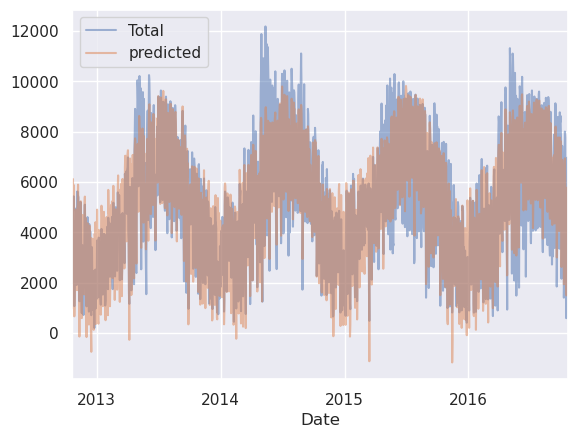

In [99]:
import seaborn
seaborn.set()
daily[['Total', 'predicted']].plot(alpha=0.5);

In [100]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -1174.536301
Tue               -855.823605
Wed               -862.037235
Thu              -1178.654591
Fri              -1840.655743
Sat              -4502.576089
Sun              -4605.809905
holiday          -2377.412872
daylight_hrs       234.164926
PRCP           -338067.024371
dry day           1039.017320
Temp (C)           755.125269
annual              63.443607
dtype: float64

In [94]:


from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)



In [95]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Total            1.0    0.0
Mon              0.0    0.0
Tue              0.0    0.0
Wed              0.0    0.0
Thu              0.0    0.0
Fri              0.0    0.0
Sat             -0.0    0.0
Sun             -0.0    0.0
holiday         -0.0    0.0
daylight_hrs     0.0    0.0
annual           0.0    0.0
PRCP             0.0    0.0
Temp (C)         0.0    0.0
dry day          0.0    0.0
